In [162]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns
import common.common_pandas_lib as common

## Configuraciones

In [163]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (18, 8)

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
#pd.options.display.float_format = '{:20,.8f}'.format # suprimimos la notacion cientifica en los outputs

### Configuraciones plot

In [178]:
TAM_TITULO = 35
TAM_ETIQUETA = 30

### Configuraciones de librerias

In [165]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (18, 8)

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
#pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Carga optimizada del set de datos

In [166]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \
                
                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \

                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

### Funciones auxiliares

#### Graficos

In [167]:
font_size = 18

def crear_mapa(series, caracteristica, vmin, vmax, titulo, titulo_barra, color):
    #Creo mi mapa de mexico
    mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

    #Le pongo los tildes al archivo de estados para que me coincidan con las provincias
    mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

    #Hago un nuevo dataframe con la información del mapa y la antiguedad para cada provincia
    gdf = mexico.set_index("ADMIN_NAME").join(series)
    
    #Grafico el mapa

    #Base donde se va a dibujar
    fig, base = plt.subplots(1, figsize=(10, 6))

    #Si les parece que los ejes están de más, pongan off
    base.axis("on")

    #Pido que me coloreé en base a la caracteristica determinada
    gdf.plot(column=caracteristica, cmap=color, linewidth=0.8, ax=base, edgecolor="0.8")

    #Setteo el título al gráfico
    base.set_title(titulo, fontsize = font_size)
    
    #Agrego la barra que indica la antiguedad
    # l:left, b:bottom, w:width, h:height
    cbax = fig.add_axes([1, 0.15, 0.02, 0.65])   
    cbax.set_title(titulo_barra)
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cbax)

#### Otras

In [168]:
def crear_porcentaje_superficie_mexico_df(df_mexico):
    provincia = []
    porcentaje = []
    area_total = df_mexico["Shape_Area"].sum()
    for index, row in df_mexico.iterrows():
        provincia.append(row["ADMIN_NAME"])
        porcentaje.append((row["Shape_Area"] * 100) / area_total)
    dic = {"provincia": provincia, "porcentaje de area": porcentaje}
    return pd.DataFrame(dic)

### Datos

In [169]:
METROS_CUADRADOS_MEXICO = 1.97255*10**12
### ¿Cómo se relacionan los metros totales con el tamaño de una provincia? ¿Las provincias de mayor superficie tienen un promedio de metros totales mayor por propiedad que las de menor superficie?

## Cantidad de NAN en campos a analizar

### Cantidad de NAN en provincia:

In [170]:
n_provincia_nan = df["provincia"].isnull().sum()
n_provincia_nan

155

### Cantidad de NAN en escuelascercanas:

In [171]:
n_metrostotales_nan = df["metrostotales"].isnull().sum()
n_metrostotales_nan

51467

In [172]:
df = df.dropna(subset=["provincia"])
df = df.dropna(subset=["metrostotales"])

### ¿Cuál es el promedio de metros totales por provincia?

In [173]:
provincia_promedio_metrostotales= df.groupby("provincia")["metrostotales"].mean()

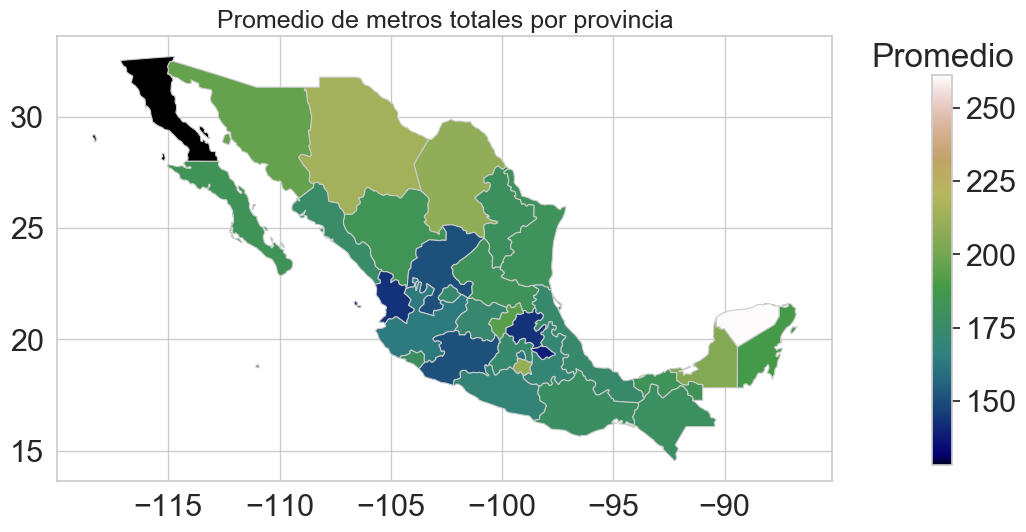

In [174]:
crear_mapa(provincia_promedio_metrostotales, "metrostotales", provincia_promedio_metrostotales.min(), 
           provincia_promedio_metrostotales.max(), "Promedio de metros totales por provincia", "Promedio", "gist_earth")

### ¿Cómo se relacionan los metros totales con el tamaño de una provincia? ¿Las provincias de mayor superficie tienen un promedio de metros totales mayor por propiedad que las de menor superficie?

In [175]:
provincias_cantidad_propiedades = df["provincia"].value_counts()
provincias_mas_propiedades = provincias_cantidad_propiedades.nlargest(6)
provincias_mas_propiedades = list(provincias_mas_propiedades.index)
df_reducido = df[df["provincia"].isin(provincias_mas_propiedades)]
df_reducido = df_reducido.sort_values("provincia")

In [176]:
metrostotales_provincia_estadistica = common.agrupar_calcular_estadisticas_desagrupar(df_reducido, "provincia", "metrostotales")
metrostotales_provincia_estadistica = metrostotales_provincia_estadistica.sort_values("provincia")

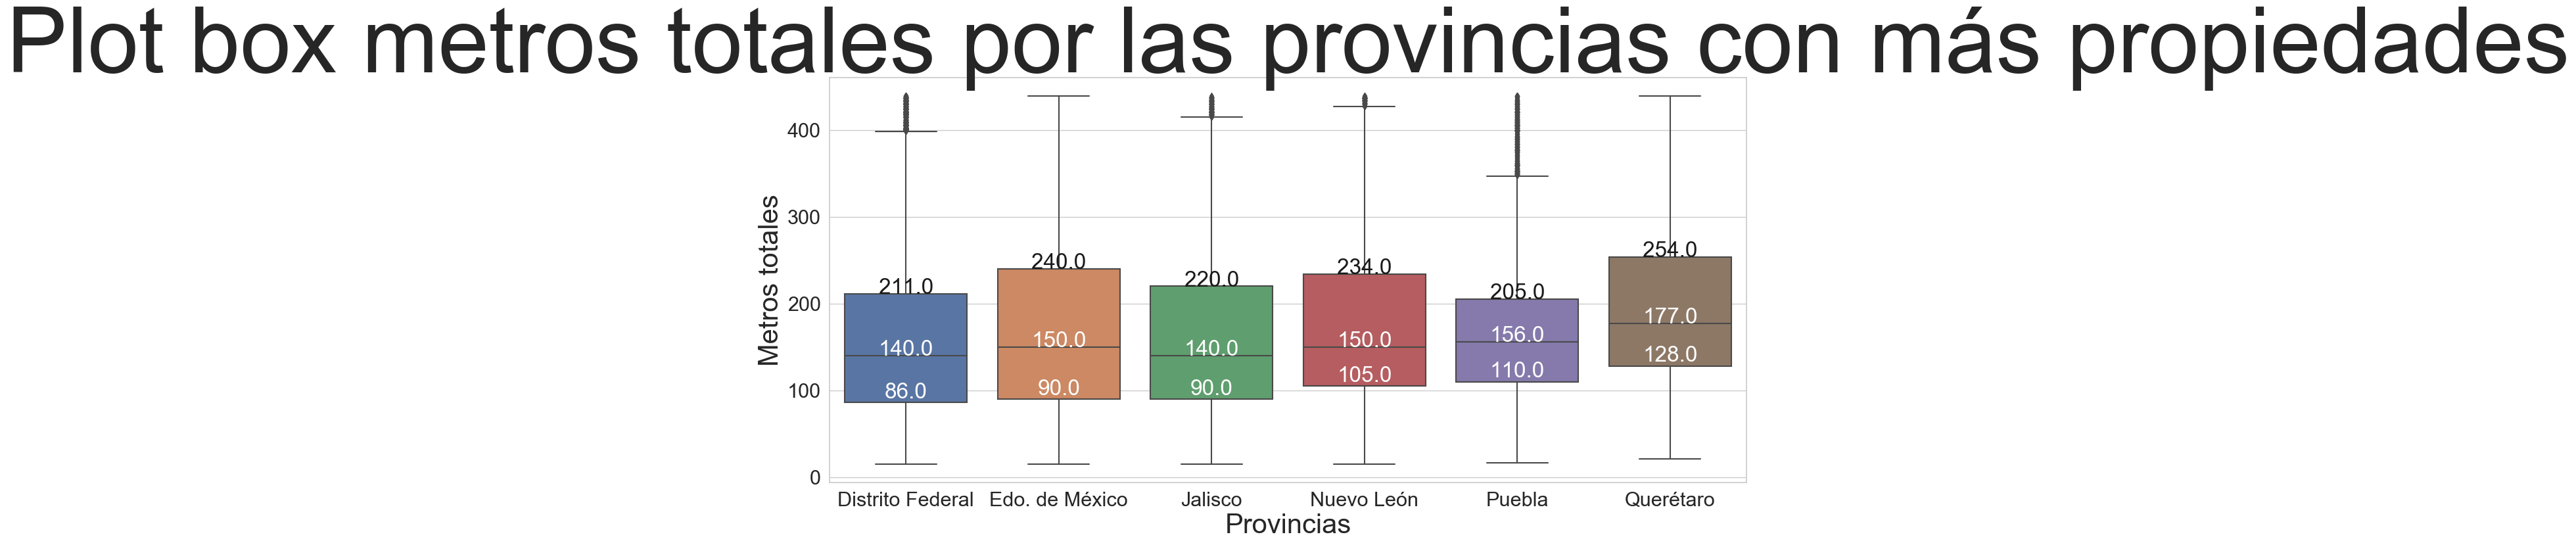

In [179]:
plot_box_metrostotales = sns.boxplot(x="provincia", y="metrostotales", data=df_reducido)
common.agregar_serie_plot(plot_box_metrostotales, metrostotales_provincia_estadistica["metrostotales_median"],
                          metrostotales_provincia_estadistica["metrostotales_median"], "w", 0, 0)
common.agregar_serie_plot(plot_box_metrostotales, metrostotales_provincia_estadistica["metrostotales_cuantil_1"],
                          metrostotales_provincia_estadistica["metrostotales_cuantil_1"], "w", 0, 5)
common.agregar_serie_plot(plot_box_metrostotales, metrostotales_provincia_estadistica["metrostotales_cuantil_3"],
                          metrostotales_provincia_estadistica["metrostotales_cuantil_3"], "k", 0, 0)
common.setear_titulos_plot(plot_box_metrostotales, "Plot box metros totales por las provincias con más propiedades",
                          "Provincias", "Metros totales")